<b>Modèle de scoring - Partis 2 | Construction du modèle de scoring</b>

<img src="https://www.ionos.fr/digitalguide/fileadmin/DigitalGuide/Teaser/deep-learning-vs-machine-learning-t.jpg">

# Apporche méthodologique


Notre modèle de scoring prend en compte les données historiques de la banque 'Prêt à dépenser afin de définir si le client remboursera ou non le crédit qu'il sollicite.

Ce modèle est donc un modèle de classification binaire où la cible, 'Target', vaut 0 lorsque le client a remboursé son crédit et 1 lorsqu'il a eu des difficultés de remboursement.
Avec cette configuration au niveau de la Target, nous développerons un modèle qui prédira si le client a des difficultés de remboursement. Ainsi :
- 0 signifie que le client n'aura pas de difficultés de remboursement.
- 1 signifie que le client aura des difficultés de remboursement.

Afin de construire un modèle performant, nous procéderons en premier lieu à définir les métriques qui serviront à caractériser les performances du modèle, ensuite nous sélectionnerons les modèles (ou algorithme de machine learning) de classification binaire pouvant répondre à notre problématique tout en expliquant leurs principes de fonctionnement. Enfin nous entraîneront notre modèle dans un premier temps en sélectionnant les meilleurs features, c'est-à-dire les variables qui auront le plus d'impact dans la prédiction du modèle, puis en faisant varier les hyper-paramètres des modèles de scoring.

Pour finir, nous conclurons avec une comparaison des modèles.

### Sélection des métriques d'évaluation

<img src="https://user.oc-static.com/upload/2017/03/02/14884666421501_P2C1-1.png">


Avant de sélectionnez nos métriques, revenons sur les définitions fondamentales en classification binaire.
Comme présenté sur la figure ci-dessus, il existe plusieurs cas de figure lorsque notre modèle prédit un résultat :
- Le résultat est <b>Négatif</b>: Le client n'a pas eu de difficulté de remboursement (0).
- Le résultat est <b>Positif</b> : Le client a eu des difficulté de remboursement (1).
- Le résultat est <b>Vrai</b> : Le modèle a prédit correctement la cible.
- Le résultat est <b>Faux</b> : Le modèle n'a pas prédit correctement la cible.

Ainsi il extiste quatre situations possibles :
- Le résultat est <b> Vrai Positif (VP)</b> : Le client a eu des difficultés de remboursement et le modèl a eu juste.
- Le résultat est <b> Vrai Négatif (VN)</b> : Le client n'a pas eu de difficultés de remboursement et le modèle a eu juste.
- Le résultat est <b> Faux Positif (FP)</b> : Le client n'a pas eu de difficultés et le modèle n'a pas eu juste.
- Le résultat est <b> Faux Négatif (FN)</b> : Le client a eu des difficultés de remboursement et le modèle n'a pas eu juste.

Tout l'intérêt du modèle consiste à prédire correctement lorsque le client a eu des difficultés de remboursement et donc maximiser les vrais positifs tout en minimisant les faux négatifs - lorsque le modèle prédit que le client n'a pas eu de difficultés de remboursement (négatif) alors que le modèle se trompe. C'est-à-dire qu'il faut éviter d'accorder un crédit aux clients qui ne peuvent pas rembourser et prédire correctement les clients qui ne pourront pas rembourser.

<b>Pourquoi ce choix ?</b>
Nous pensons que pour une banque de prêt, il vaudrait mieux ne pas prêter à un client qui a les capacités de rembourser (faux positif), et donc de ne pas faire de bénéfice, plutôt que de prêter a un client qui n'a pas les capacités de rembourser (faux négatif) et donc de faire des pertes.

Pour cela, nous pouvons calculer plusieurs indicateurs :
- La justesse : (VP + VF) / (VP+VN + VFP + FN) proportion de prédiction vraie.
Cet indicateur, nommé accuracy en machin learning, ne sera pas l'indicateur le plus efficace, car la cible est déséquilibrée, nous avons lors de notre exploration de données que la répartition de notre target est de 92% de valeurs 0 et 8% de valeurs 1. En ne prédisant que des 0 le modèle aura automatiquement un accuracy de 0.92. Cet indicateur ne sera donc pas utilisé pour l'entraînement du jeu du modèle.

Nous pouvons aussi observer la précision et le rappel du modèle décrit par :
- La précision : VP / (VP+FP) proportion de vrai positif sur l'ensemble des positifs prédits.
- Rappel : VP / (VP + FN) proportion de prédiction correcte parmi les personnes ayant eu un incident dans le remboursement du prêt.
- f1 score : 2(precision*rapel)/(precision+rapel) qui est la moyenne harmonique de la précision et du rappel, plus F1 est proche de 1 plus la précision et le rappel seront grand. Une grande valeur de F1 signifie que le modèle prédit correctement les Vrais positifs (les clients capables réellement de rembourser le prêt).


Nous observerons également d'autres métriques complémentaires aux deux précédentes :
- Temps d'entraînement, ce qui nous permettra d'observer les modèles qui apprennent les plus vite.

Enfin, nous observerons 2 graphiques :
- La Matrice de confusion, qui synthétisera dans un graphe les différentes valeurs : VP, FP, FP, FN
- La courbe d'apprentissage, qui affichera l'évolution de l'apprentissage du modèle en fonction du pourcentage du jeu de données utilisé pour l'apprentissage.

<b>La métrique que nous utiliserons pour l'entrainement du jeu de donnée sera la métrique f1_score</b>

Nous faisons ce choix, car après expérimentation, lorsque les modèles sont entraînés avec les métriques 'recall' ou 'précision', les modèles ont tendance a avoir de très bons score sur la métrique choisie, mais des scores faible sur les autres indicateurs. Lorsque la métrique 'recall' est utilisée par exemple, les indicateurs accuracy et précision s'effondre, ce qui signifie dans ce cas que le modèle aura davantage tandance à prédire la Target 1, ce qui augmentera le Nombre de Vrai positif et diminuera le nombre faux négatif. Le recall sera alors en croissance, mais en augmentant le nombre de prédictions 1 le nombre de faux positif augmentera et fera donc diminuer l'indicateur de précision. Le f1_score est donc un bon compromis entre le rappel et la précision.

In [13]:
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# import de la base de données nétoyée 
data = pd.read_csv('data.csv',encoding="utf8")

# import des modèles entraînés
try: 
    save_dict = pickle.load(open("model_trained", "rb"))
    import_ = True
except:
    import_ = False
    
print('Import successfully')

# import depuis sklearn des metrics f1_score et de la matrice de confusion
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

#import du modul time pour chronométrer les modèles
from sklearn.model_selection import GridSearchCV

# Definition de la varialbe X,y
X = data.drop(['Unnamed: 0','TARGET'], axis=1).values
y = data.TARGET

Import successfully


# Features sélection
Dans cette partie, nous appliquerons trois approches pour la sélection des features qui servirons à entraîner nos modèles.

<b>Sélection par la variance des variable - VarianceThreshold</b> : 
Nous appliquerons dans un premier temps la méthode de sélection par la variance. Cette méthode élimine les variables qui varient le moins.

<b>Sélection par récurtion</b> : ensuite nous appliquerons une méthode de sélection par récursion, cette méthode consiste à entrainer plusieurs fois le jeux de données en retirant une variable après l'autre et en observant le score du modèle. Cette méthode prend la classe donc les variables en fonction de l'impact de leur absence sur le score du modèle.

<b>Boruta</b> : enfin nous appliquons l'algorithme de features sélection Boruta qui a la particularité, contrairement à la méthode par récursion, d'entraîner le jeu de données avec des variables sélectionnées aléatoirement combinées avec les variables initiales. Les variables sélectionnées aléatoirement sont appelées "shadow features". Les variables sont sélectionnées si elles ont une importance plus grande que les shadow features associées.

Afin de sélectionner la méthode la plus pertinente, nous nous baserons sur le score du modèle après entraînement avec les variables sélectionnées.

In [2]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from boruta import BorutaPy


if import_:
    selector = save_dict['selecteur'][0]
    selector5 = save_dict['selecteur'][1]
    feat_selector = save_dict['selecteur'][2]
    
else:
    # Instanciation du modèle RandomForest
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)


    ### Selecteur par la méthode de la variance
    selector =  VarianceThreshold(threshold=0.2)
    selector.fit_transform(X,y)


    ### Selecteur par récurance
    selector5 = RFECV(rf, 
                      step=1, #nombre de variable supprimer par entrainement
                      min_features_to_select=10, #nombre de variable minimum sélectionée en fin d'entrainement
                     cv = 5) # nombre de split pour la cross validation
    selector5.fit(X,y)


    ### Seleceur Boruta
    feat_selector = BorutaPy(rf, n_estimators='auto', 
                            verbose= 2,
                            random_state=1)
    feat_selector.fit(X, y)

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

def analyse(selector):
    clf.fit(selector.transform(X_train),y_train)
    return recall_score(y_test, clf.predict(selector.transform(X_test)))

sc_var = analyse(selector)
sc_rec = analyse(selector5)
sc_bor = analyse(feat_selector)

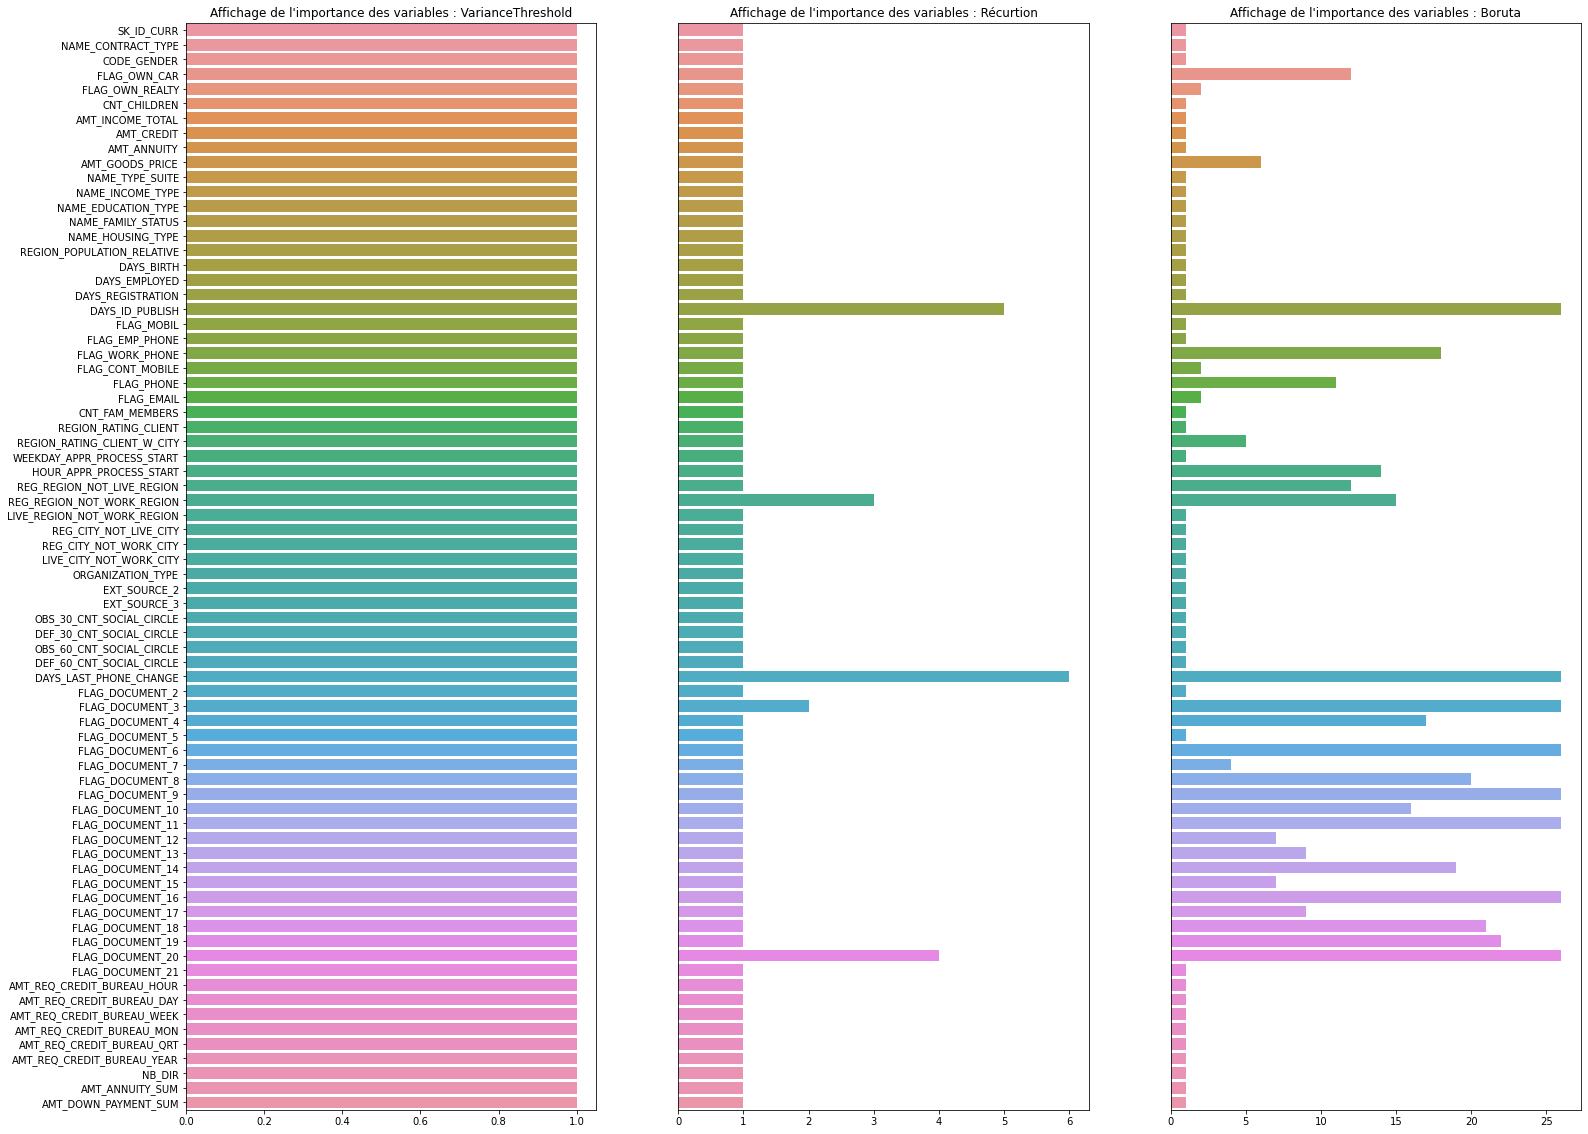

In [16]:
# Affichage de l'importance des variable pour le sélecteur de variance
plt.figure(figsize=(25,20))
plt.subplot(1, 3, 1)
plt.title(f"Affichage de l'importance des variables : VarianceThreshold")
sns.barplot(x=selector.variances_,
            y=data.drop(['Unnamed: 0','TARGET'], axis=1).columns)

# Affichage de l'importance des variable pour le sélecteur de variance
plt.subplot(1, 3, 2)
plt.title(f"Affichage de l'importance des variables : Récurtion")
sns.barplot(x=selector5.ranking_,
            y=data.drop(['Unnamed: 0','TARGET'], axis=1).columns)
ax = plt.gca()
ax.axes.yaxis.set_visible(False)
                 
# Affichage de l'importance des variable pour le sélecteur de variance
plt.subplot(1, 3, 3)
plt.title(f"Affichage de l'importance des variables : Boruta")
sns.barplot(x=feat_selector.ranking_,
            y=data.drop(['Unnamed: 0','TARGET'], axis=1).columns
           )
ax = plt.gca()
ax.axes.yaxis.set_visible(False)     
plt.show()

X_t = feat_selector.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.33, random_state=42, stratify=y)

<b>Bilan de notre features sélection : </b> 

La première méthode utilisée n'est pas très efficace, en effet sélectionner les variables en fonction de leur variance sous-entend que les variables qui varient très peu n'ont pas d'incidence sur la prédiction du modèle. Cette hypothèse n'est pas suffisante et ne se démontre pas après cette méthode de sélection.
De plus les scores obtenus à partir des variables sélectionnées par cette méthode sont les moins élevés des trois méthodes.

La seconde méthode est le pus robuste, car elle nécessite l'entraînement successif d'un modèle avec le jeu de données privé de certaine de ces variables. Par conséquent, cette méthode demande plus de temps de calcul.

Enfin, la méthode Boruta est la plus efficace, bien qu'elle prenne plus de temps à sélectionner les features, de plus elle apporte un complément a la méthode de récurtion, car elle confirme bien les variables sélectionnées par cette dernière.

Par la suite, nous conserverons donc les features sélectionner par la méthode Boruta.

# Entraînement des modèles

## Méthodologie d'entrainement

L'entraînement des modèles de scoring suivront une procédure identique.
Dans un premier temps, nous présenterons les modèles ainsi que leurs spécificités.
<b>Les différentes étapes de l'entrainement</b>
- L'identification des hypers paramètres.
- Partition du jeu de données par Cross Validation,
- Entrainement du modèle via GridSearchCV,
- Évaluation du modèle à partir des métriques précédemment sélectionnées,
- Observation de la courbe d'apprentissage,
- Enregistrement du modèle avec les meilleures hypers-paramètres.


<b>Les modèles sélectionnés</b>
- Régression Logistique
- K-nearest neighbors (K plus proche voisin)
- DecisionTreeClassifier (Arbre de décision)
- XGBoost

<b>A fin de comparer les résultats de nos modèles nous utiliseront un modèle de référence.</b>

Ce modèle de référence aura la particularité d'être relativement simple car il prédira aléatoirement des valeurs entre 0 ou 1. Avec cette spécificité, nous pourrons observer si nos modèles sélectionnés auront de meilleures performances que ce modèle de référence.


Le jeu de données est séparé en deux parties, l'un servira à l'entraînement des modèle, l'autre servira à tester et à comparer les modèles. À noter que la répartition des Target n'étant pas uniforme, lorsque nous diviserons le jeu de données, nous veillerons à ce que les proportions des Targets 0 et 1 soit identiques dans chaque partie.

In [17]:
X_t = feat_selector.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.33, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Normalisation du jeu d'entrainement
X_train = scaler.fit_transform(X_train)

In [18]:
def training(model, param_grid, scoring='f1', n= None,  true=False, bilan_=False):
    plot = None
    grid = GridSearchCV(model, param_grid, 
                        cv=5, 
                        scoring=scoring)

    a = time.perf_counter()

    grid.fit(X_train[:n], y_train[:n])
    b = time.perf_counter()
    
    t = b-a
    model = grid.best_estimator_
    acc = accuracy_score(y_train[:n], model.predict(X_train[:n]))
    p = precision_score(y_train[:n], model.predict(X_train[:n]))
    r = recall_score(y_train[:n], model.predict(X_train[:n]))
    f1 = f1_score(y_train[:n], model.predict(X_train[:n]))
    
    print(f"Fin de l'entrainement - Best_score {scoring} : {grid.best_score_}")
    
    if bilan_:
        print(f"Après entrainement du modèle les meileurs paramètres : {grid.best_params_}")
        bilan(model, acc, p, r, f1, t, plot)
    if true:
        plot = learn_curv(model,X_train,y_train,Z=10, n = n)
    
    return model, acc, p, r, f1, t, plot


def learn_curv(model,X_train,y_train,Z, n = None,scoring='f1'):
    N, train_scor, val_scor = learning_curve(model, 
                                             X_train[:n], 
                                             y_train[:n], 
                                             train_sizes= np.linspace(0.2,1,Z),
                                             cv = 5,
                                            scoring=scoring)
    
    N = np.around( (N/X_train[:n].shape[0]*100),decimals=2)
    plt.figure(figsize=(20,7))
    plt.plot(N, train_scor.mean(axis=1), label = 'train')
    plt.plot(N, val_scor.mean(axis=1), label = 'validation')
    plt.xlabel('train_sizes')
    plt.ylabel('Precision score')
    plt.legend()
    
    plt.show()
    return [N, train_scor.mean(axis=1), val_scor.mean(axis=1)]

def plot_learning(model):
    
    N = save_dict[model][-1][0]
    train_scor = save_dict[model][-1][1]
    val_scor = save_dict[model][-1][2]
    
    plt.figure(figsize=(20,7))
    plt.title(f"Courbe d'apprentissage du model : {model}")
    plt.plot(N, train_scor, label = 'train')
    plt.plot(N, val_scor, label = 'validation')
    plt.xlabel('train_sizes')
    plt.ylabel('Precision score')
    plt.legend()   
    plt.show()
    
def bilan(model, acc, p, r, f1, t, plot):
    print(f"""La moyenne harmonique Precision/Rappel (f1_score) est : {f1},
Le temps d'entrainement est  de {t} secondes,
Le score de recall est de : {r},
Le score de précision est de : {p}
La score accuracy est de : {acc},
  
    """)

## Entraînement des modèles de classification

Les métriques d'évaluation étant sélectionnées, nous présenterons à présent les différents modèles de scoring qui nous permettrons de déterminer si notre client aura des difficultés de remboursement. Pour cela nous présenterons 4 modèles en précisant pour chaque modèle à quelle famille il appartient, quel est son principe de fonctionnement.

### Classification régression logistique : LogisticRegression

La méthode de classification par régression logistique consiste à séparer nos données via une fonction linéaire qui calcule la probabilité qu'un point appartienne à une classe. La fonction linéaire étant définie sur +∞ et -∞ ont applique une transformation logistique qui définira donc la probabilité du point, comprise entre 0 et 1 d'appartenir à la classe 0 et la classe 1.

<img src="https://user.oc-static.com/upload/2017/07/04/14991799233039_P2C1-1.png">

Nous utiliserons le module LogisticRegression de la bibliothèque de sklearn. Pour ce modèle la Cross Validation divisera le jeu de données d'entrainement en 5 parties. Les hypers paramètres qui seront ajustés pendant l'entrainement seront :
- C : Inverse de la force de régularisation ; doit être un nombre réel positif. Comme dans les machines à vecteurs de support, des valeurs plus petites spécifient une régularisation plus forte.
- penalty : Permet de préciser la norme utilisée dans la pénalisation.Permet de préciser la norme utilisée dans la pénalisation.
- max_iter : Nombre maximum d'itérations nécessaires pour que les solveurs convergent.
- n_jobs : Nombre de cœurs de processeur utilisés lors de la parallélisation sur des classes.

La moyenne harmonique Precision/Rappel (f1_score) est : 0.2751306413301663,
Le temps d'entrainement est  de 62.40376729998388 secondes,
Le score de recall est de : 0.696470446756058,
Le score de précision est de : 0.17142476579496516
La score accuracy est de : 0.7037587124080222,
  
    


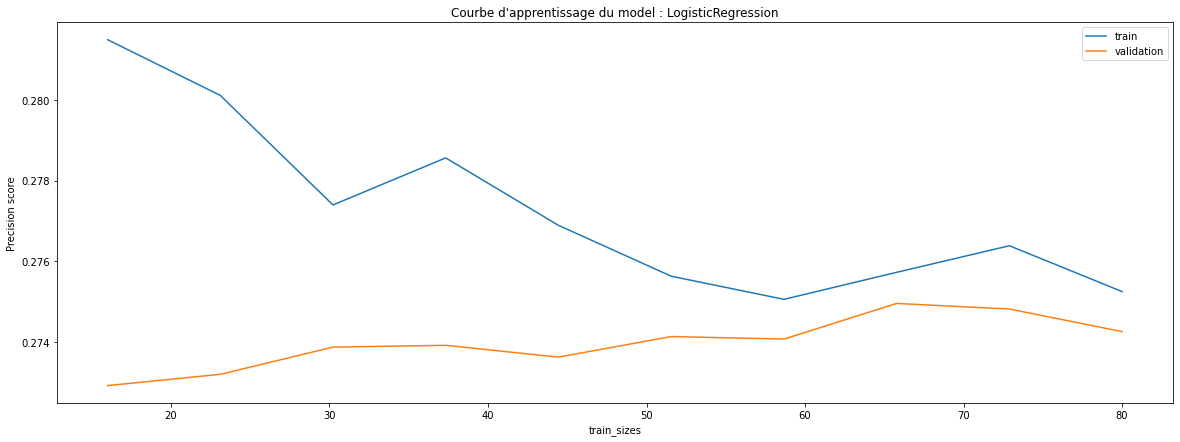

In [22]:
# Import du modèle de regression logistique depuis Sklean
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(class_weight='balanced')

#GridSearch CV
param_grid = {
    #'C' : np.arange(0.25, 2, .25),
    #'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    #'max_iter' :  np.arange(50, 100, 10),
    #'n_jobs' : np.arange(1, 4, 1)
    'C' : [1],
    'penalty' : ['l2'],
    'max_iter' :  [50],
    'n_jobs' : [3]
}

if import_:
    clf_ = save_dict['LogisticRegression']
    bilan(clf_[0],clf_[1],clf_[2],clf_[3],clf_[4],clf_[5],clf_[6])
    plot_learning('LogisticRegression')
else:
    # Entrainement du modèl
    clf_ = training(clf, param_grid, bilan_=True, true =True)

Les meilleurs paramètres pour ce modèle sont les paramètres par défaut.
Sur la courbe d'apprentissage, nous voyons que le score est croissant et n'atteint pas une valeur stable pour la totalité du jeu d'entraînement. Avec d'avantage de données le modèle pourrait vraisemblablement avoir un meilleur score en utilisant ce modèle. De plus, le score de précision, c'est-à-dire le taux de Vrai positif, s'élève à 0.17 et le score de rappel est quant à lui de 0.70.

### Approche des plus proche voisins : KNN

L'approche k-NN, de l'anglais k-nearest neighbors, est une méthode d'apprentissage supervisée qui consiste à prédire en fonction d'une entrée x la cible y en fonction de k plus proches voisins, c'est-à-dire que le modèle cherche les k entrés qui se rapprochent le plus de l'entrée x et prédit la cible correspondant à ces k plus proches entrées.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/330px-KnnClassification.svg.png">

Pour ce modèle la Cross Validation divisera le jeu de données d'entrainement en 5 parties.

Les hypers paramètres qui seront ajustés pendant l'entrainement seront :
- n_neighbors : Le nombre de voisin plus proche pris en compte par le modèle.
- p : Paramètre de puissance pour la métrique de Minkowski. Lorsque p = 1, cela équivaut à utiliser manhattan_distance (l1) et euclidean_distance (l2) pour p = 2. Pour p arbitraire, minkowski_distance (l_p) est utilisé.
- weights : fonction de poids utilisée dans la prédiction.

La moyenne harmonique Precision/Rappel (f1_score) est : 1.0,
Le temps d'entrainement est  de 131.8853718 secondes,
Le score de recall est de : 1.0,
Le score de précision est de : 1.0
La score accuracy est de : 1.0,
  
    


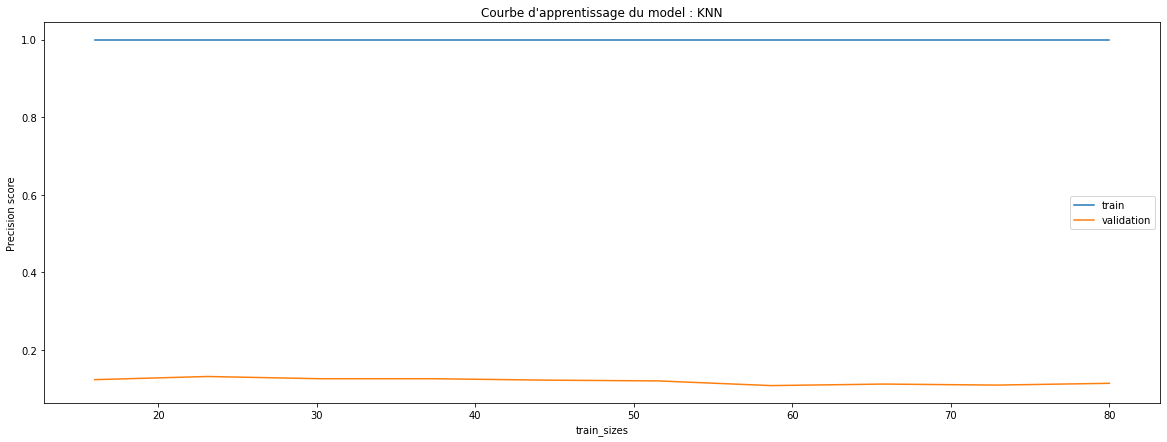

In [23]:
# Import du modèle de regression logistique depuis Sklean
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

#GridSearch CV
param_grid = {
    #'n_neighbors' : np.arange(2, 5, 1),
    #'p' : np.arange(1, 5, 1),
    #'weights': ['uniform', 'distance']
    'n_neighbors' :[2],
    'p' : [4],
    'weights': ['distance']
}

if import_:
    knn_ = save_dict['KNN']
    bilan(knn_[0],knn_[1],knn_[2],knn_[3],knn_[4],knn_[5],knn_[6])
    plot_learning('KNN')
else:
    # Entrainement du modèl
    knn_ = training(knn, param_grid, n= 10000, bilan_=True, true =True)

On constate que le temps de calcul est beaucoup plus grand que pour l'entraînement précédent.
De plus, le score de rappel est à 0.1 et la courbe d'apprentissage nous montre que quel que soit le nombre de données le modèle n'améliore pas ses scores.

### Arbre de descision : DecisionTreeClassifier


L’apprentissage par arbre de décision désigne une méthode basée sur l'utilisation d'un arbre de décision comme modèle prédictif. Dans ces structures d'arbre, les feuilles représentent les valeurs de la variable-cible et les embranchements correspondent à des combinaisons de variables d'entrée qui mènent à ces valeurs.
Ces modèles ont l'avantage de fournir une explication des décisions prises par le modèle, il est, en effet, possible d'observer pour chaque prédiction qu'elles ont été les valeurs pour chaque embranchement de l'arbre de décision.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b7/Arbre_de_decision.jpg">

Pour ce modèle la Cross Validation divisera le jeu de données d'entrainement en 5 parties.
Les hypers paramètres qui seront ajustés pendant l'entrainement seront :
- max_depth : La profondeur maximale de l'arbre. 
- splitter  : La stratégie utilisée pour choisir la division à chaque nœud.
- min_samples_split : Le nombre minimum d'échantillons requis pour diviser un nœud interne

La moyenne harmonique Precision/Rappel (f1_score) est : 0.30959978120156806,
Le temps d'entrainement est  de 14.71299500000896 secondes,
Le score de recall est de : 0.7146894353917383,
Le score de précision est de : 0.19759941481579998
La score accuracy est de : 0.7427000213563205,
  
    


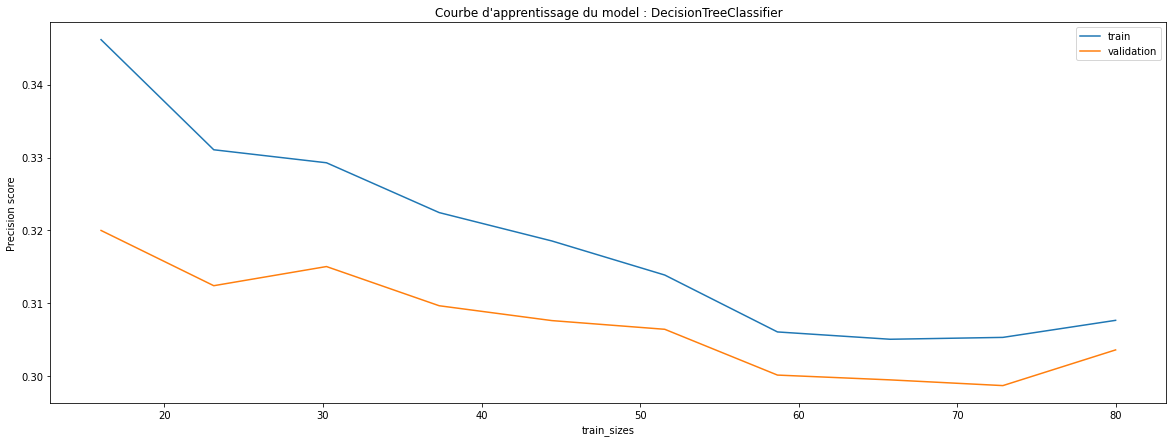

In [24]:
#GridSearch CV
param_grid = {
    #'max_depth' : np.arange(2, 7, 1),
    #'splitter': ['best', 'random'],
    #'min_samples_split' : np.arange(1, 6, 1)
    'max_depth' : [6],
    'splitter': ['best'],
    'min_samples_split' : [2]
}

if import_:
    tree_ = save_dict['DecisionTreeClassifier']
    bilan(tree_[0],tree_[1],tree_[2],tree_[3],tree_[4],tree_[5],tree_[6])
    plot_learning('DecisionTreeClassifier')
    
else:
    # Import du modèle de regression logistique depuis Sklean
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(class_weight='balanced')
    
    # Entrainement du modèl
    tree_ = training(tree, param_grid, n= 10000, bilan_=True, true =True)

Le Temps de calcul est de 14 secondes ce qui très rapide, le modèle dispose d'une profondeur de 3 embranchements, et la valeur finale de précision est de 1. La courbe d'apprentissage nous montre que le modèle n'avait besoin que de 80% des données pour atteindre ce score.

### Gradient boosting : XGBoost

L'amplification de gradient est une technique d'apprentissage automatique pour la régression, la classification et d'autres tâches, qui produisent un modèle de prédiction sous la forme d'un ensemble de modèles de prédiction faibles, généralement des arbres de décision.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Multi-Layer_Neural_Network-Vector-Blank.svg/225px-Multi-Layer_Neural_Network-Vector-Blank.svg.png">

Pour ce modèle, la Cross Validation divisera le jeu de données d'entraînement en 5 parties.

Les hypers paramètres qui seront ajustés pendant l'entraînement seront :
- n_estimators : La profondeur maximale de l'arbre.
- splitter : La stratégie utilisée pour choisir la division à chaque nœud.
- loss : La fonction de perte à optimiser. « déviance » fait référence à la déviance (= régression logistique) pour la classification avec des sorties probabilistes. En cas de perte, l'amplification du gradient « exponentiel » récupère l'algorithme AdaBoost.


La moyenne harmonique Precision/Rappel (f1_score) est : 0.37260984304828926,
Le temps d'entrainement est  de 51.681273399997735 secondes,
Le score de recall est de : 0.7258733690096807,
Le score de précision est de : 0.25063322675746375
La score accuracy est de : 0.8026821597064476,
  
    


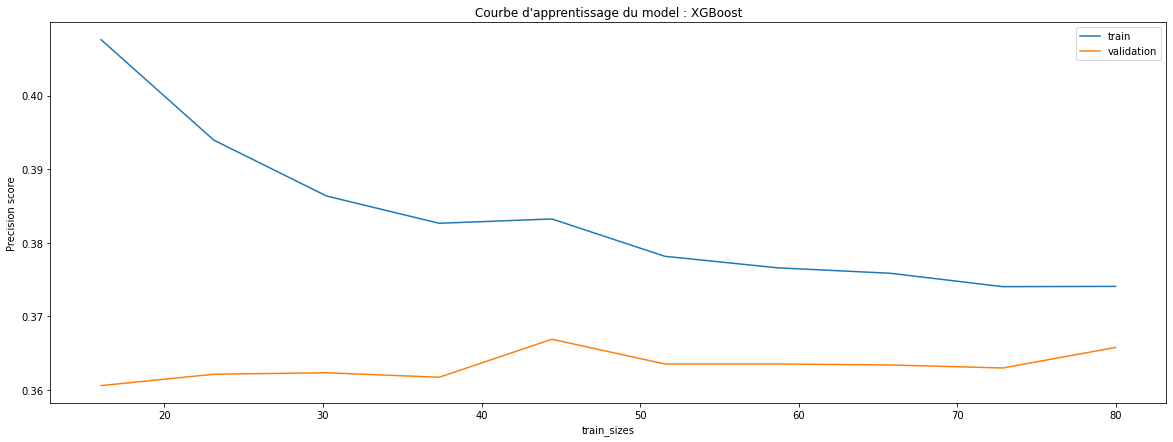

In [25]:
#GridSearch CV
param_grid = {
    #'scale_pos_weight' : np.arange(10, 100, 10),
    #'n_estimators' : np.arange(60, 70, 10),
    #'max_depth': np.arange(3, 4, 1),
    'scale_pos_weight' : [10],
    'n_estimators' :[60],
    'max_depth': [3],
}
if import_:
    xg_ = save_dict['XGBoost']
    bilan(xg_[0],xg_[1],xg_[2],xg_[3],xg_[4],xg_[5],xg_[6])
    plot_learning('XGBoost')
else:
    # Import du modèle de regression logistique depuis Sklean
    import xgboost as xgb
    xg = xgb.XGBClassifier(objective='reg:squarederror')
    # Entrainement du modèl
    xg_ = training(xg, param_grid, scoring='f1', bilan_=True, true =True)

Le Temps d'entraînement est de 667 secondes ce qui est le second temps le plus élevé derrière le modèle KNN, la valeur de précision est de 0.92 et la courbe d'apprentissage nous montre que le modèle n'a pas terminé sont entraînement.

## Comparaison, évaluation des modèles et Importance des features

Tous les modèles ont été entraînés, nous pouvons à présent les comparer en fonction de nos indicateurs.

Nous pouvons apercevoir par la suite les données détaillées pour chaque modèle avec notamment le classement de l'importance des variables.

In [26]:
from tabulate import tabulate
import ipywidgets as widgets
y_pred_ref = np.random.randint(0,2,len(y_test))
model_ref = [accuracy_score(y_test,y_pred_ref),
recall_score(y_test,y_pred_ref),
precision_score(y_test,y_pred_ref),
f1_score(y_test,y_pred_ref),0]

y_pred=knn_[0].predict(X_test[:1000])
knn_indicaterus = [accuracy_score(y_test[:1000],y_pred),
recall_score(y_test[:1000],y_pred),
precision_score(y_test[:1000],y_pred),
f1_score(y_test[:1000],y_pred), knn_[-2]]
indicateurs_model = [model_ref,clf_[1:-1], knn_indicaterus,tree_[1:-1],xg_[1:-1]]

model = ["Modèle de référence","LogisticRegression", "KNN", "DecisionTreeClassifier", "XGBoost"]
index = ['Accuracy', 'Précision','Recall','f1-score', "learning time (s)"]

tab_indicateurs = pd.DataFrame(np.around(indicateurs_model,decimals=2),index=model,columns = index)

print(tabulate(tab_indicateurs, headers = 'keys', tablefmt = 'psql'))

+------------------------+------------+-------------+----------+------------+---------------------+
|                        |   Accuracy |   Précision |   Recall |   f1-score |   learning time (s) |
|------------------------+------------+-------------+----------+------------+---------------------|
| Modèle de référence    |       0.5  |        0.5  |     0.08 |       0.14 |                0    |
| LogisticRegression     |       0.7  |        0.17 |     0.7  |       0.28 |               62.4  |
| KNN                    |       0.92 |        0    |     0    |       0    |              131.89 |
| DecisionTreeClassifier |       0.74 |        0.2  |     0.71 |       0.31 |               14.71 |
| XGBoost                |       0.8  |        0.25 |     0.73 |       0.37 |               51.68 |
+------------------------+------------+-------------+----------+------------+---------------------+


In [27]:
@widgets.interact(Model = model[1:])
def ploting(Model):
    
    d = {"LogisticRegression" : clf_[0], 
        "KNN" : knn_[0], 
         "DecisionTreeClassifier" : tree_[0], 
         "XGBoost" : xg_[0]      
    }
    
    plot = {"LogisticRegression" : clf_[-1], 
        "KNN" : knn_[-1], 
         "DecisionTreeClassifier" : tree_[-1], 
         "XGBoost" : xg_[-1]   
    }
    
    print(f'Indicateur du model {Model}')
    print(pd.DataFrame(tab_indicateurs.loc[Model]))
    
    print(f"Matrice de confusion du modèle : {Model}")
    plot_confusion_matrix(d[Model], X_train, y_train)
    
    
    N = plot[Model][0]
    train_scor = plot[Model][1]
    val_scor = plot[Model][2]
    
    plt.figure(figsize=(20,7))
    plt.title(f"Courbe d'apprentissage du model : {Model}")
    plt.plot(N, train_scor, label = 'train')
    plt.plot(N, val_scor, label = 'validation')
    plt.xlabel('train_sizes')
    plt.ylabel('Precision score')
    plt.legend()   
    plt.show()

interactive(children=(Dropdown(description='Model', options=('LogisticRegression', 'KNN', 'DecisionTreeClassif…

Le model <b>XGBoost</b> est le modèl qui dispose des meillieurs caractéristiques. Avec le jeu de données 'test' voici la valeur des indicateurs :

In [28]:
def scoring(model):
    y_pred=model[0].predict(X_test)
    print(f"""L'accuracy du model est de : {accuracy_score(y_test,y_pred)}
Le score de rappel (recall) est de : {recall_score(y_test,y_pred)}
Le score de précision est de : {precision_score(y_test,y_pred)}
Le score de f1 est de : {f1_score(y_test,y_pred)}""")
    
scoring(xg_)

L'accuracy du model est de : 0.8596732082225028
Le score de rappel (recall) est de : 0.07203706471379465
Le score de précision est de : 0.08425100506904387
Le score de f1 est de : 0.07766677408959072


Le score de rappel est le meilleur obtenu : 0,27, la précision est de 0,98 et le temps de calcule est le meilleur obtenu deplus, le modèle 

Avec ce modèl la banque pourra prédire avec une très grande précision, c'est à dire avec un très faire nombre de faux positif (client prédit par le modèle en mesure de rembourser le prêt mais qui s'avère être faux).

### Explicabilités des décisions

Nous souhaitons à présent fournir aux agent de la banque un moyen d'appercevoir quels ont été les fetures qui ont été prise en cosidération par le modèl de scoring.
  
  
Sur le graphique suivant nous pouvons observer l'importance des variable sur l'ensemble du jeu de données pour le modèle qui a été sélectionnée, le modèle DecisionTreeClassifier.

In [29]:
from googletrans import Translator

translator = Translator()
def trad(x):
    return translator.translate(text=x, dest='fr',src='en').text

path = './Projet+Mise+en+prod+-+home-credit-default-risk/'
with open(path + 'HomeCredit_columns_description.csv', encoding="utf8", errors='ignore') as f:
    df_info = pd.read_csv(f)

In [30]:
import shap  
import matplotlib.colors as cl
import ipywidgets as widgets

path = './Projet+Mise+en+prod+-+home-credit-default-risk/'

with open(path + 'HomeCredit_columns_description.csv', encoding="utf8", errors='ignore') as f:
    df_info = pd.read_csv(f)

columns = data.drop(['Unnamed: 0','TARGET'], axis=1).columns
featurs_list = {u : columns[u] for u in range(len(columns))}
features_select = [featurs_list[u] for u in feat_selector.ranking_.argsort()[:feat_selector.n_features_]]

@widgets.interact(Model = ["DecisionTreeClassifier","XGBoost"])
def explain(Model):
    
    d = {"DecisionTreeClassifier" : tree_[0], 
         "XGBoost" : xg_[0]} 
    
    explainer = shap.TreeExplainer(d[Model])

    # calculate shap values. This is what we will plot.
    shap_values = explainer.shap_values(X_test)

    # custom colour plot
    colors = ["#9bb7d4", "#0f4c81"]           
    cmap = cl.LinearSegmentedColormap.from_list("t", colors)
    shap.summary_plot(shap_values, X_test,cmap=cmap,alpha=0.4,feature_names=features_select)


@widgets.interact(feature = features_select)
def feature_description(feature):
    print(f'Description de la variable {feature} : {trad(df_info.Description[df_info.Row == feature].values[0])}')

interactive(children=(Dropdown(description='Model', options=('DecisionTreeClassifier', 'XGBoost'), value='Deci…

interactive(children=(Dropdown(description='feature', options=('SK_ID_CURR', 'WEEKDAY_APPR_PROCESS_START', 'LI…

On constate que pour ce modèle de scoring que les variabes qui ont le plus d'impacte sont respectivement :
- Flag_Document_7
- Flag_mobil
- RegionRating
- Day_employed

Ainsi le modèle semble indiquer que l'apport du document 7 au dossier bancaire, l'ajout d'un numéro de téléphone, l'évaluation de la Région du lieu d'habitation et la date d'embauche du client impacte le comporte du remborsement du prêt.

Enfin pour chacune des entrées nous pouvons également déterminer quelle a été la variable qui a eu le plus d'incidence de le processuce de décision.

In [31]:
import lime
import lime.lime_tabular

@widgets.interact(n_client = (2,len(X_train[:1000]),1))
def explian(n_client):
    print(f'Informations relatives au client SK_ID_CURR : {int(data.iloc[n_client].SK_ID_CURR)}')
    # LIME has one explainer for all the models
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train[:1000], 
                                                       feature_names=features_select,
                                                      class_names=['Dificulté de remboursement', 'Sans difficultés'], 
                                                       verbose=True, mode='classification')
    
    exp = explainer.explain_instance(X_train[n_client], 
                                     xg_[0].predict_proba, 
                                     num_features=6)
    exp.show_in_notebook(show_table=True)

interactive(children=(IntSlider(value=501, description='n_client', max=1000, min=2), Output()), _dom_classes=(…

# Conclusion



<img src="https://www.telecom-paris.fr/wp-content-EvDsK19/uploads/2019/01/Mast%C3%A8re-Sp%C3%A9cialis%C3%A9-ia-2.jpg">


À l'issue de notre analyse exploratoire puis de notre phase d'entraînement, nous pouvons déterminer quel algorithme de classification est le plus adapté à notre problématique.


Notre objectif étant de déterminer si un client sollicitant un prêt était en mesure de le rembourser.
Pour cela, nous avons analysé quelles étaient les critères déterminants via notre analyse multivariée puis grâce à notre méthodologie de sélection de feature, nous avons sélectionné un certain nombre de variables. Nous avons ainsi pu observer que :
- Pour l'entraînement 44 variables suffiraient contre 122 dans le jeu de données initial,
- Le score de rappel était la métrique la plus importante pour l'observation des clients qui étaient susceptibles de faire un défaut de paiement.
- Différents modèles pouvaient être utilisés pour construire ce modèle de scoring, chacun avait son principe de fonctionnement et ses domaines d'application.
- Le modèle que nous avons sélectionné était le modèle de Gradient Boosting (XGBoost) qui affiche le score de rappel le plus élevé parmi nos 4 modèle.
- Nous avons mis à disposition des agent des outils d'analyse qui permettent de déterminer quels sont les variables qui affectent la décision de notre algorithme et un outil qui peut déterminer pour chaque individu de notre jeu de donnée quelle sont les facteurs qui entrent le plus en compte dans la prédiction de ses facultés de rembourser le prêt qu'il sollicite.


Pour revenir plus en détail sur les caractéristiques du modèle de scoring retenu :
- Son accuracy est 93% c'est-à-dire que sur le jeu de donnée test, le modèle prédit correctement la cible à 93%. Ce score étant à mettre en parallèle du déséquilibre de la target. Pour rappel, 91 % des individus n'avaient pas de difficulté de remboursement. Une prédiction naïve aurait donc un accuracy score de 91%
- Son score de rappel est de 22% su le jeu d'entraînement test. Ce qui signifie qu'il peut détecter, sur les personnes ayant fait défaut de remboursement 22% des individus,
- Son score de précision est de 96%, c'est-à-dire que lorsque le modèle prédit que le client fera défaut de remboursement cela est possible à 96%.
- Le temps d'entraînement pour sélectionner les meilleurs paramètres était de 51 econdes ce qui était le modèle le plus rapide à converger. 

In [23]:
import pickle
# save model to file
d_model = {"LogisticRegression" : clf_, 
           "KNN" : knn_, 
           "DecisionTreeClassifier" : tree_, 
           "XGBoost" : xg_,
           "selecteur" : [selector, selector5, feat_selector]
    }
pickle.dump(d_model, open("model_trained", "wb"))